In [1]:
from config import*
from Wfamily import*
from Model import*

/envs/common/lib/python3.10/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


family_len:  24649


In [2]:
model_WPINN = WPINN(input_size = len_collocation, 
                    family_size = len(family),
                    num_hidden_layers1 = 4, 
                    num_hidden_layers2 = 6, 
                    hidden_neurons1 = 100,
                    hidden_neurons2 = 100).to(device)

optimizer1 = optim.Adam(model_WPINN.parameters(), lr=1e-5)#, weight_decay=1e-4)

# milestones = [1000, 2000, 4000] 
# scheduler = MultiStepLR(optimizer1, milestones=milestones, gamma=0.1)

c, b = model_WPINN(x_collocation, y_collocation)
len(c[0])

24649

In [3]:
# model_WPINN.load_state_dict(torch.load('model_parameters copy.pth'))

In [3]:
x_interior = x_collocation.clone()
y_interior = y_collocation.clone()

def wpinn_loss(model):   
    global c, b
    c, b = model(x_interior, y_interior)


    u = torch.mv(Wfamily, c[0]) + b[0]
    u_x = torch.mv(DWx, c[0])
    u_y = torch.mv(DWy, c[0])
    u_xx = torch.mv(DW2x, c[0])
    u_yy = torch.mv(DW2y, c[0])

    v = torch.mv(Wfamily, c[1]) + b[1]
    v_x = torch.mv(DWx, c[1])
    v_y = torch.mv(DWy, c[1])
    v_xx = torch.mv(DW2x, c[1])
    v_yy = torch.mv(DW2y, c[1])

    p_x = torch.mv(DWx, c[2])
    p_y = torch.mv(DWy, c[2])

    u_pred_bc_x_left = torch.mv(Wbc_x_left, c[0]) + b[0]
    u_pred_bc_x_right = torch.mv(Wbc_x_right, c[0]) + b[0]
    u_pred_bc_y_lower = torch.mv(Wbc_y_lower, c[0]) + b[0]
    u_pred_bc_y_upper = torch.mv(Wbc_y_upper, c[0]) + b[0]

    v_pred_bc_x_left = torch.mv(Wbc_x_left, c[1]) + b[1]
    v_pred_bc_x_right = torch.mv(Wbc_x_right, c[1]) + b[1]
    v_pred_bc_y_lower = torch.mv(Wbc_y_lower, c[1]) + b[1]
    v_pred_bc_y_upper = torch.mv(Wbc_y_upper, c[1]) + b[1]

    u_data = (torch.mv(Wdata, c[0]) + b[0])
    v_data = (torch.mv(Wdata, c[1]) + b[1])
    pred_vel_data = (u_data**2 + v_data**2)**0.5

    
    pde_loss = torch.mean((u_x + v_y) ** 2) +\
               torch.mean((u*u_x + v*u_y + p_x - (u_xx + u_yy)/Re)**2) +\
               torch.mean((u*v_x + v*v_y + p_y - (v_xx + v_yy)/Re)**2)

    bc_loss = torch.mean(u_pred_bc_x_left** 2) + torch.mean(u_pred_bc_x_right** 2) + torch.mean(u_pred_bc_y_lower** 2) + torch.mean((u_pred_bc_y_upper - 1)** 2) +\
              torch.mean(v_pred_bc_x_left** 2) + torch.mean(v_pred_bc_x_right** 2) + torch.mean(v_pred_bc_y_lower** 2) + torch.mean(v_pred_bc_y_upper**2)
    
    data_loss = torch.mean((pred_vel_data - vel_data)**2) + (torch.mv(Wzero,c[2])+b[2])**2
    
    total_loss = pde_loss + bc_loss + data_loss
    
    return total_loss, pde_loss, bc_loss, data_loss

def train_wpinn(model, optimizer, num_prints):
    # Training loop
    pde_losses = []
    bc_losses = []
    for epoch in tqdm(range(num_epochs)):

        torch.cuda.empty_cache()
        
        optimizer.zero_grad()

        total_loss, pde_loss, bc_loss, data_loss = wpinn_loss(model)
        
        total_loss.backward()
        optimizer.step()
        # scheduler.step()

        # current_lr = optimizer.param_groups[0]['lr']
    
        
        if epoch % ((num_epochs-1)/num_prints) == 0:

            with torch.no_grad():
                u_pred = torch.mv(WTest, c[0].cpu()) + b[0].cpu()
                v_pred = torch.mv(WTest, c[1].cpu()) + b[1].cpu()
                vel_pred = ((u_pred**2 + v_pred**2)**0.5).reshape(n_test, n_test)


            vel_errL2 = (torch.sum(torch.abs(vel_ref-vel_pred)**2))**0.5 / (torch.sum(torch.abs(vel_ref)**2))**0.5
            vel_errMax = torch.max(torch.abs(vel_ref-vel_pred))
            
            print(f'Epoch [{epoch}/{num_epochs-1}], '
                  f'Total Loss: {total_loss.item():.6f}\t '
                  f'PDE Loss: {pde_loss.item():.6f}\t '
                  f'Data Loss: {data_loss.item():.6f}\t '
                  f'BC Loss: {bc_loss.item():.6f}, \n'
                  f'\t\t  vel:  RelativeL2: {vel_errL2}\t '
                  f'Max: {vel_errMax} \n')
            
        torch.cuda.empty_cache()
    
    return [pde_losses, bc_losses]

In [4]:
torch.cuda.empty_cache()

num_epochs = 10**4+1
l = train_wpinn(model_WPINN, optimizer1, num_prints=20)

  0%|          | 0/10001 [00:00<?, ?it/s]

  0%|          | 2/10001 [00:00<51:26,  3.24it/s]  

Epoch [0/10000], Total Loss: 18.352530	 PDE Loss: 16.004269	 Data Loss: 0.448426	 BC Loss: 1.899835, 
		  vel:  RelativeL2: 1.9119973247817825	 Max: 1.0305365728378295 



  5%|▌         | 502/10001 [01:30<35:58,  4.40it/s]

Epoch [500/10000], Total Loss: 0.040954	 PDE Loss: 0.011682	 Data Loss: 0.003084	 BC Loss: 0.026188, 
		  vel:  RelativeL2: 0.6120548663510748	 Max: 0.7653539776802063 



 10%|█         | 1002/10001 [02:59<32:55,  4.55it/s]

Epoch [1000/10000], Total Loss: 0.031491	 PDE Loss: 0.010129	 Data Loss: 0.001937	 BC Loss: 0.019426, 
		  vel:  RelativeL2: 0.5620296767431443	 Max: 0.749987781047821 



 15%|█▌        | 1502/10001 [04:29<31:59,  4.43it/s]

Epoch [1500/10000], Total Loss: 0.022530	 PDE Loss: 0.006612	 Data Loss: 0.000697	 BC Loss: 0.015222, 
		  vel:  RelativeL2: 0.5183813918799471	 Max: 0.7508838176727295 



 20%|██        | 2002/10001 [05:58<29:11,  4.57it/s]

Epoch [2000/10000], Total Loss: 0.034374	 PDE Loss: 0.020153	 Data Loss: 0.000514	 BC Loss: 0.013707, 
		  vel:  RelativeL2: 0.4933757521486568	 Max: 0.7478253841400146 



 25%|██▌       | 2502/10001 [07:28<28:23,  4.40it/s]

Epoch [2500/10000], Total Loss: 0.018983	 PDE Loss: 0.005585	 Data Loss: 0.000411	 BC Loss: 0.012988, 
		  vel:  RelativeL2: 0.4735068935568494	 Max: 0.7432303428649902 



 30%|███       | 3002/10001 [08:58<26:03,  4.48it/s]

Epoch [3000/10000], Total Loss: 0.017533	 PDE Loss: 0.005039	 Data Loss: 0.000382	 BC Loss: 0.012113, 
		  vel:  RelativeL2: 0.43828259185775964	 Max: 0.736354410648346 



 35%|███▌      | 3502/10001 [10:27<24:27,  4.43it/s]

Epoch [3500/10000], Total Loss: 0.012054	 PDE Loss: 0.001505	 Data Loss: 0.000030	 BC Loss: 0.010519, 
		  vel:  RelativeL2: 0.1711333623266723	 Max: 0.7262357473373413 



 40%|████      | 4002/10001 [11:57<22:36,  4.42it/s]

Epoch [4000/10000], Total Loss: 0.011921	 PDE Loss: 0.002041	 Data Loss: 0.000011	 BC Loss: 0.009869, 
		  vel:  RelativeL2: 0.09207436514865396	 Max: 0.7294694781303406 



 45%|████▌     | 4502/10001 [13:27<20:41,  4.43it/s]

Epoch [4500/10000], Total Loss: 0.010411	 PDE Loss: 0.000924	 Data Loss: 0.000006	 BC Loss: 0.009481, 
		  vel:  RelativeL2: 0.08663401136907165	 Max: 0.7284229397773743 



 50%|█████     | 5002/10001 [14:56<18:18,  4.55it/s]

Epoch [5000/10000], Total Loss: 0.012797	 PDE Loss: 0.003564	 Data Loss: 0.000010	 BC Loss: 0.009223, 
		  vel:  RelativeL2: 0.08177951329107777	 Max: 0.7235533595085144 



 55%|█████▌    | 5502/10001 [16:26<16:34,  4.52it/s]

Epoch [5500/10000], Total Loss: 0.010277	 PDE Loss: 0.001373	 Data Loss: 0.000007	 BC Loss: 0.008897, 
		  vel:  RelativeL2: 0.07918959482999333	 Max: 0.7305655479431152 



 60%|██████    | 6002/10001 [17:56<14:57,  4.46it/s]

Epoch [6000/10000], Total Loss: 0.009772	 PDE Loss: 0.000990	 Data Loss: 0.000005	 BC Loss: 0.008777, 
		  vel:  RelativeL2: 0.0789902518169107	 Max: 0.727179765701294 



 65%|██████▌   | 6502/10001 [19:25<13:09,  4.43it/s]

Epoch [6500/10000], Total Loss: 0.009316	 PDE Loss: 0.000771	 Data Loss: 0.000005	 BC Loss: 0.008540, 
		  vel:  RelativeL2: 0.07564387077723	 Max: 0.7281397581100464 



 70%|███████   | 7002/10001 [20:55<11:11,  4.46it/s]

Epoch [7000/10000], Total Loss: 0.009154	 PDE Loss: 0.000741	 Data Loss: 0.000004	 BC Loss: 0.008408, 
		  vel:  RelativeL2: 0.07496287216461653	 Max: 0.7274999618530273 



 75%|███████▌  | 7502/10001 [22:24<09:12,  4.52it/s]

Epoch [7500/10000], Total Loss: 0.009036	 PDE Loss: 0.000760	 Data Loss: 0.000005	 BC Loss: 0.008272, 
		  vel:  RelativeL2: 0.07475466243911402	 Max: 0.7273200154304504 



 80%|████████  | 8002/10001 [23:54<07:30,  4.43it/s]

Epoch [8000/10000], Total Loss: 0.009304	 PDE Loss: 0.001118	 Data Loss: 0.000006	 BC Loss: 0.008180, 
		  vel:  RelativeL2: 0.0738044374440405	 Max: 0.7261046171188354 



 85%|████████▌ | 8502/10001 [25:23<05:38,  4.43it/s]

Epoch [8500/10000], Total Loss: 0.008791	 PDE Loss: 0.000720	 Data Loss: 0.000004	 BC Loss: 0.008067, 
		  vel:  RelativeL2: 0.07422103295635175	 Max: 0.7276382446289062 



 90%|█████████ | 9002/10001 [26:53<03:38,  4.57it/s]

Epoch [9000/10000], Total Loss: 0.008696	 PDE Loss: 0.000727	 Data Loss: 0.000004	 BC Loss: 0.007965, 
		  vel:  RelativeL2: 0.07346353119031183	 Max: 0.7269732356071472 



 95%|█████████▌| 9502/10001 [28:23<01:49,  4.57it/s]

Epoch [9500/10000], Total Loss: 0.008680	 PDE Loss: 0.000806	 Data Loss: 0.000004	 BC Loss: 0.007869, 
		  vel:  RelativeL2: 0.0723143094324489	 Max: 0.7266262173652649 



100%|██████████| 10001/10001 [29:52<00:00,  5.58it/s]

Epoch [10000/10000], Total Loss: 0.008518	 PDE Loss: 0.000727	 Data Loss: 0.000004	 BC Loss: 0.007787, 
		  vel:  RelativeL2: 0.07243474098133097	 Max: 0.7269325256347656 



In [13]:
trained_c = c
trained_b = b

name = ['0_u','1_v','2_p']
for i in range(3):
    file_name = "coeff_"+name[i]+".csv"
    np.savetxt(file_name, c[i].detach().cpu(), delimiter=",")

biases_save = [bias.detach().cpu() for bias in b]
file_name = "biases.csv"
np.savetxt(file_name, biases_save, delimiter=",")


file_name = "vel_pred_400.csv"
np.savetxt(file_name, vel_pred, delimiter=",")

torch.save(model_WPINN.state_dict(), 'model_parameters.pth')


RelativeL2: 0.07243474098133097 	 Max: 0.7269325256347656


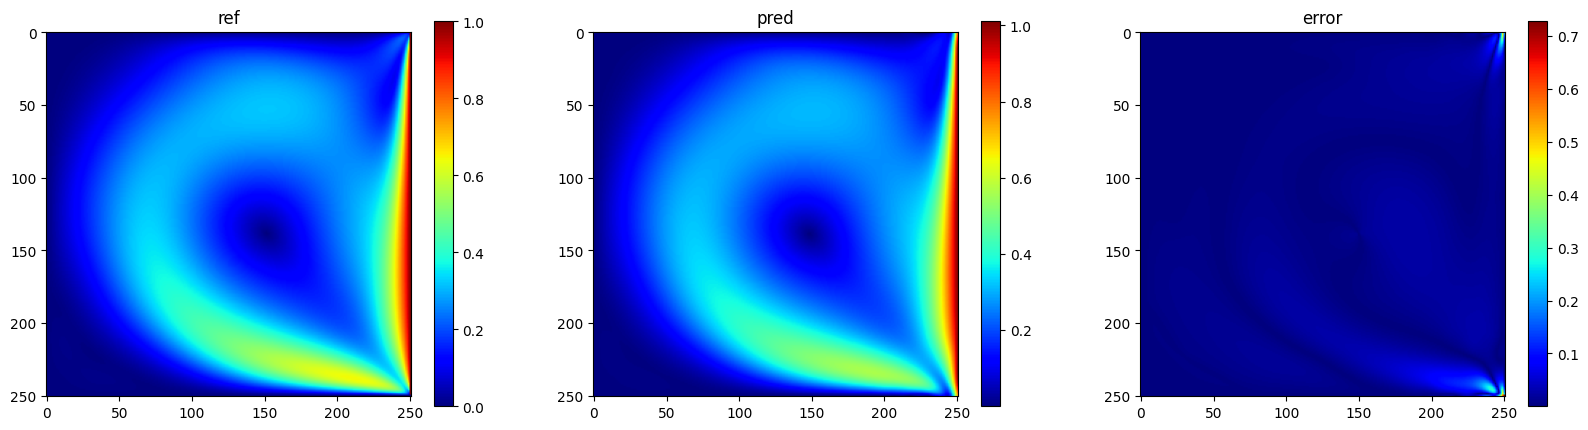

In [9]:
with torch.no_grad():
    u_pred = torch.mv(WTest, c[0].cpu()) + b[0].cpu()
    v_pred = torch.mv(WTest, c[1].cpu()) + b[1].cpu()
    vel_pred = ((u_pred**2 + v_pred**2)**0.5).reshape(n_test, n_test).cpu()


vel_errL2 = (torch.sum(torch.abs(vel_ref-vel_pred)**2))**0.5 / (torch.sum(torch.abs(vel_ref)**2))**0.5
vel_errMax = torch.max(torch.abs(vel_ref-vel_pred))
            
print(f'RelativeL2: {vel_errL2} \t Max: {vel_errMax}')


fig = plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.imshow(vel_ref, cmap='jet')
plt.colorbar(cmap='jet')
plt.title('ref')

plt.subplot(1,3,2)
plt.imshow(vel_pred, cmap='jet')
plt.colorbar(cmap='jet')
plt.title('pred')

plt.subplot(1,3,3)
plt.imshow(abs(vel_pred-vel_ref), cmap='jet')
plt.colorbar(cmap='jet')
plt.title('error')
plt.savefig('Re400.jpg')
plt.show()

torch.cuda.empty_cache()

In [15]:
cord1_ghia = torch.linspace(0,1,500)
cord2_ghia = torch.tensor([0.5]*len(cord1_ghia))

jx = family[:, 0].cpu()
jy = family[:, 1].cpu() 
kx = family[:, 2].cpu() 
ky = family[:, 3].cpu()

Wval_u = gaussian(cord2_ghia, cord1_ghia, jx, jy, kx, ky).T
Wval_v = gaussian(cord1_ghia, cord2_ghia, jx, jy, kx, ky).T


u_pred_ghia = (torch.mv(Wval_u, c[0].cpu()) + b[0].cpu()).detach().numpy()
v_pred_ghia = (torch.mv(Wval_v, c[1].cpu()) + b[1].cpu()).detach().numpy()

np.savetxt("u_pred_ghia_400.csv", u_pred_ghia)
np.savetxt("v_pred_ghia_400.csv", v_pred_ghia)
